In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
from torch import nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize

random.seed(42)
reprocess_raw =  True

batch_size = 10 # documents
learning_rate = 5e-5
n_epochs = 5

task_map = {'Quantity':1}
# task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4} # uncomment for multi-class
num_classes = len(task_map)

# model_name = 'allenai/biomed_roberta_base'
model_name = 'bert-base-cased'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging easier

data_size_reduce = 1 # multiplier for making small datasets



In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

In [3]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [4]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [5]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [6]:
#### train/dev/test split options

random.seed(42)

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

n_doc = len(combo_docs)
split_train = int(np.round(n_doc * percent_to_train))
split_dev = split_train + int(np.round(n_doc * percent_to_dev))

train_docs = combo_docs[:split_train]
dev_docs = combo_docs[split_train:split_dev]
test_docs = combo_docs[split_dev:]

train_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))
dev_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))
test_docs = random.sample(combo_docs, int(len(combo_docs)*data_size_reduce))

In [7]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']

        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [max(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S0960148113005727-739_T1-1,S0960148113005727-739,T1-1,Quantity,"[208, 214]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsCount']}
S0021979713004438-2148_T176-6,S0021979713004438-2148,T176-6,MeasuredEntity,"[17, 41]",HasProperty,T116-6,"[1059, 1063]","[1063, 1063]",NaN,NaN,NaN
S0032386113005454-2055_T1-5,S0032386113005454-2055,T1-5,Quantity,"[798, 814]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0019103512003995-1283_T3-1,S0019103512003995-1283,T3-1,MeasuredProperty,"[129, 145]",HasQuantity,T1-1,"[149, 155]","[155, 155]",NaN,NaN,NaN
S0378383911001669-1112_T1-2,S0378383911001669-1112,T1-2,Quantity,"[59, 65]",NaN,NaN,NaN,NaN,mm,[2608],NaN
S0022399913003358-943_T3-2,S0022399913003358-943,T3-2,MeasuredProperty,"[1486, 1507]",HasQuantity,T1-2,"[1482, 1485]","[1507, 1507]",NaN,NaN,NaN
S0927024813002420-975_T1-9,S0927024813002420-975,T1-9,Quantity,"[1053, 1060]",NaN,NaN,NaN,NaN,eV,"[174, 2559]",NaN


In [9]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids

    for doc in doc_list:
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        taskAnnotIdCharMap = {} # to check for token collision
        
        for task in list(taskLabelMap.keys()):
            #print(task)
            annotId = doc_annot.loc[doc_annot['annotType']==task].index
            # print(annotId)
            spans = list(doc_annot.loc[doc_annot['annotType']==task]['annotSpan'])
            # print(spans)
            for span in spans:
                # print(span)
                span = list(range(span[0],span[-1]))
                # print(span)
                for spanCharIdx in span:
                    # print(spanCharIdx)
                    taskCharMap[spanCharIdx] = taskLabelMap[task]
                # print(taskCharMap)
                    # taskAnnotIdCharMap[spanCharIdx] = annotId

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [10]:
combo_txt

{'S0006322312001096-1136': 'Data were drawn from the Whitehall II study with baseline examination in 1991; follow-up screenings in 1997, 2003, and 2008; and additional disease ascertainment from hospital data and registry linkage on 5318 participants (mean age 54.8 years, 31% women) without depressive symptoms at baseline. Vascular risk was assessed with the Framingham Cardiovascular, Coronary Heart Disease, and Stroke Risk Scores. New depressive symptoms at each follow-up screening were identified by General Health Questionnaire caseness, a Center for Epidemiologic Studies Depression Scale score ≥16, and use of antidepressant medication.',
 'S0006322312001096-1177': 'The Whitehall II study is a prospective cohort study of British civil servants established in 1985 to study associations between risk factors, pathophysiological changes, and clinical disease (22). The target population was all London-based office staff, aged 35 to 55, working in 20 civil service departments on recruitmen

In [11]:
################# TOKENIZE #################

stage1_train_ds = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


In [12]:
stage1_n_train

448

In [13]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

toks = list(stage1_dev_ds.loc[stage1_dev_ds['doc_or_sent_id']=='S0022000014000026-18167']['input_ids'])

print(toks[0])

tokenizer.decode(toks[0])

[101, 1249, 1103, 6593, 1104, 1412, 2526, 117, 1195, 1208, 15187, 1106, 1134, 6102, 1103, 4625, 1104, 1412, 7249, 1104, 1103, 6820, 9159, 2162, 116, 9932, 117, 1134, 1138, 1151, 4448, 1105, 22480, 1439, 1412, 13117, 8297, 1105, 7289, 6700, 1193, 117, 2283, 1412, 1902, 2513, 119, 7282, 117, 1195, 1209, 6265, 170, 1295, 1104, 3209, 8313, 1105, 2174, 1844, 22655, 1116, 119, 3458, 27634, 1209, 2812, 1103, 25161, 9173, 2345, 1107, 6177, 123, 119, 122, 119, 128, 119, 794, 3894, 8160, 131, 1370, 170, 6736, 7249, 117, 1103, 1703, 1295, 1104, 8257, 1110, 152, 113, 183, 13791, 1179, 114, 1679, 14372, 119, 1188, 1169, 1129, 1562, 1118, 15639, 1115, 1103, 12133, 1104, 1103, 11810, 8257, 1110, 24778, 1103, 1112, 17162, 6451, 14426, 1295, 1104, 8257, 117, 1290, 1103, 152, 113, 183, 114, 2735, 5644, 1104, 170, 14372, 1138, 170, 4836, 1295, 1104, 8257, 1296, 132, 1606, 26258, 6379, 1106, 10407, 11810, 8257, 117, 1103, 2202, 12133, 4930, 3226, 164, 3615, 166, 119, 18491, 22319, 1193, 117, 1142, 1295, 1

'[CLS] As the conclusion of our paper, we now assess to which extent the properties of our implementation of the FATAL + algorithm, which have been expressed and verified within our modeling framework and tested experimentally, meet our design goals. Furthermore, we will discuss a number of potential improvements and future research avenues. Our exposition will follow the optimization criteria listed in Section 2. 1. 7. • Area consumption : For a suitable implementation, the total number of gates is O ( nlogn ) per node. This can be seen by observing that the complexity of the threshold gates is dominating the asymptotic number of gates, since the O ( n ) remaining components of a node have a constant number of gates each ; using sorting networks to implement threshold gates, the stated complexity bound follows [ 48 ]. Trivially, this number of gates is a factor of O ( logn ) from optimal. We conjecture that in fact this complexity is asymptotically optimal, unless one is willing to sa

In [14]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist()).to(device)
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist()).to(device)
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)
        # print(labels.shape)
        # doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            # 'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [15]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels']], batch_size, device)


/tmp/ipykernel_16547/3227256572.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)


In [16]:
# batch = batched_train_ds[3]
# model(batch['input_ids'], batch['attention_mask'])

In [17]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]

demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]

labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1}


In [18]:
print(demo_ids)

[  101 16752  8298 26720  1104 27379  1107  7403  5384 11577 23042  1219
  1103  9786  1811   117   170  5384  3476  1104   122   176  3975 25532
  1495   117  1105  7021  1107   170  2079  1104   122   119   126   782
   123   119   127   182  5415   119 24076  1116  1132 10056  1111  1103
 16251  7403  1692   119   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [19]:
print(demo_tokens)

[CLS] Concentrations of salts in Mars soil assuming deposition during the Amazonian, a soil density of 1 g cm−3, and mixing in a range of 1. 5 – 2. 6 m depth. Values are calculated for the nominal Mars case. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [20]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [21]:
print(labeled_tokens)

1 g cm ##− ##3 1 . 5 – 2 . 6 m 


In [22]:
# whether or not to add a linear layer with dropout and batch normalization
add_linear_layer = False

class Stage1model(nn.Module):
    def __init__(self, dropout=0.1):
        super(Stage1model, self).__init__()
        self.mod = AutoModel.from_pretrained(model_name,
                        num_labels=num_classes+1,hidden_dropout_prob=dropout)
        self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask,
                            output_hidden_states=True)

        y_hat = output.hidden_states[-1]

        if add_linear_layer:
            y_hat = self.norm(y_hat)
            y_hat = self.drop(y_hat)
            y_hat = self.classifier(y_hat)

        return y_hat

model = Stage1model().to(device)

print(sum(p.numel() for p in model.parameters()),"parameters!")
print("Detected", torch.cuda.device_count(), "GPUs!")

criterion = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


108312834 parameters!
Detected 1 GPUs!


In [23]:
# from torchviz import make_dot

# demo_ypred = model(demo_batch['input_ids'], demo_batch['attention_mask'])
# make_dot(demo_ypred, params=dict(list(model.named_parameters()))).render(format="png")

In [24]:
def train_epoch(model, ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).permute(0,2,1)
        
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(model, ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask).permute(0,2,1)

            loss = criterion(logits, labels)

            for dlogits, dlabels in zip(logits, labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [25]:

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_train_ds) * 3

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(model, batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(model, batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(model, batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    

# run_report = pd.DataFrame.from_dict(run_report)

  0%|          | 0/675 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Train loss: 0.09737075865268707
Eval on train set loss: 0.05571255087852478   accuracy: 0.04304722377232143
Eval on dev set loss: 0.04204411432147026   accuracy: 0.04304722377232143
============ Begin Epoch 2 ============
Train loss: 0.019264334812760353
Eval on train set loss: 0.01872824877500534   accuracy: 0.029148646763392856
Eval on dev set loss: 0.009212715551257133   accuracy: 0.029148646763392856
============ Begin Epoch 3 ============
Train loss: 0.011881375685334206
Eval on train set loss: 0.008185451850295067   accuracy: 0.029828752790178572
Eval on dev set loss: 0.003677801927551627   accuracy: 0.029828752790178572
============ Begin Epoch 4 ============
Train loss: 0.013201765716075897
Eval on train set loss: 0.011489840224385262   accuracy: 0.022578648158482144
Eval on dev set loss: 0.00603494280949235   accuracy: 0.022578648158482144
============ Begin Epoch 5 ============
Train loss: 0.0054885996505618095
Eval on train set loss: 0

In [26]:
##### todo: save reports and results to files

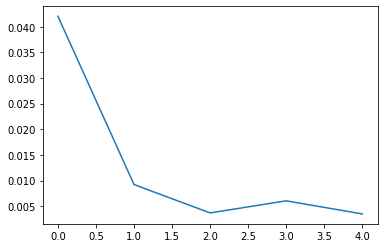

In [27]:
########################## loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

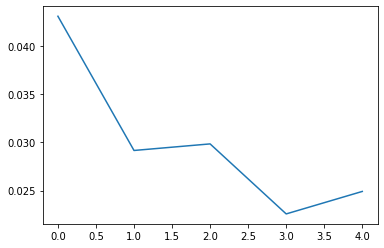

In [28]:
########################## accuracy plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()